# Analysis on RTLS
This file is shamelessly taken from the book for the most part

This is taken from the Nolan/Duncan Data Science textbook. I did not write any of it personally

First run the file [/notebooks/CaseStudy1/Clean%20Data%20(From%20Book).ipynb](/notebooks/CaseStudy1/Clean%20Data%20(From%20Book).ipynb)

In [1]:
OFFLINE_SOURCE = '../data/offline.final.trace.csv'
#ONLINE_SOURCE = '../data/online.final.trace.csv'

In [2]:
offline = read.csv(OFFLINE_SOURCE, row.names=1)
#online = readData(ONLINE_SOURCE, subMacs = macs)


In [3]:
head(offline)

time,posX,posY,orientation,mac,signal,rawTime,angle
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8a,-38,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:90,-56,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:0f:a3:39:e1:c0,-53,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:8d,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:b1:97:81,-65,1.139643e+12,0
2006-02-11 01:31:58,0,0,0,00:14:bf:3b:c7:c6,-66,1.139643e+12,0


In the anaylsis that follows we dive deep into the response variable, signal strength to answer these 2 quastions
*  What is the distribution of the repeated measure at each location and orietnation.
*  How can we characterize the relationship between signal strength and distance from the device to access point?

Distribution of signal strength at each location

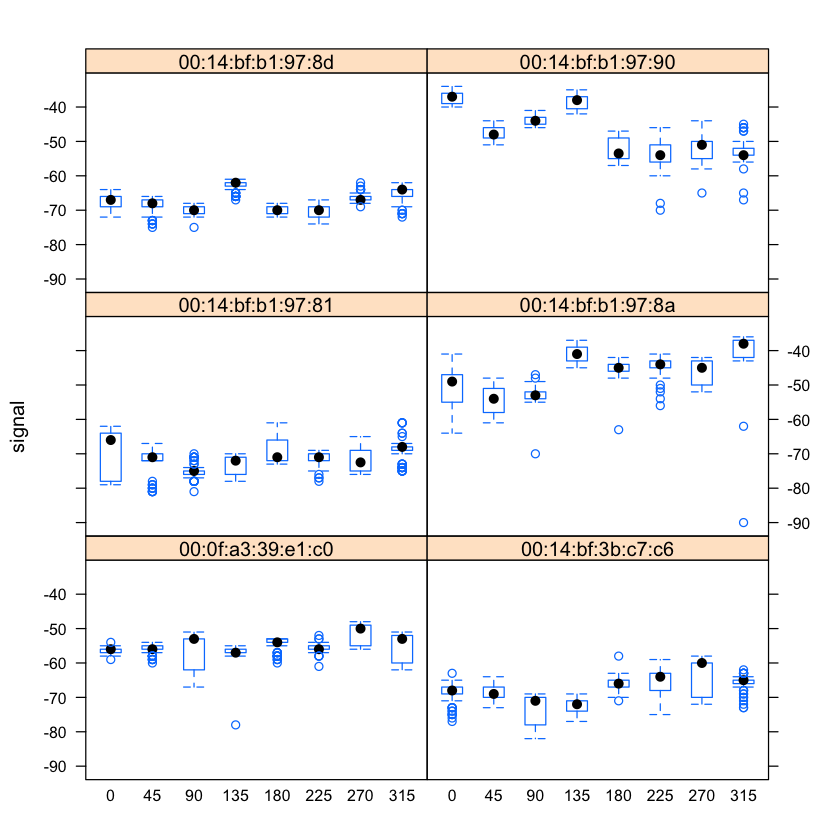

In [4]:
library(lattice)
bwplot(signal ~ factor(angle) | mac, data = offline,
subset = posX == 2 & posY == 12
& mac != "00:0f:a3:39:dd:cd",
layout = c(2,3))

Comparing the distributions of signal strength for different angles
and MAC addresses at the central location of x = 23 and y = 4

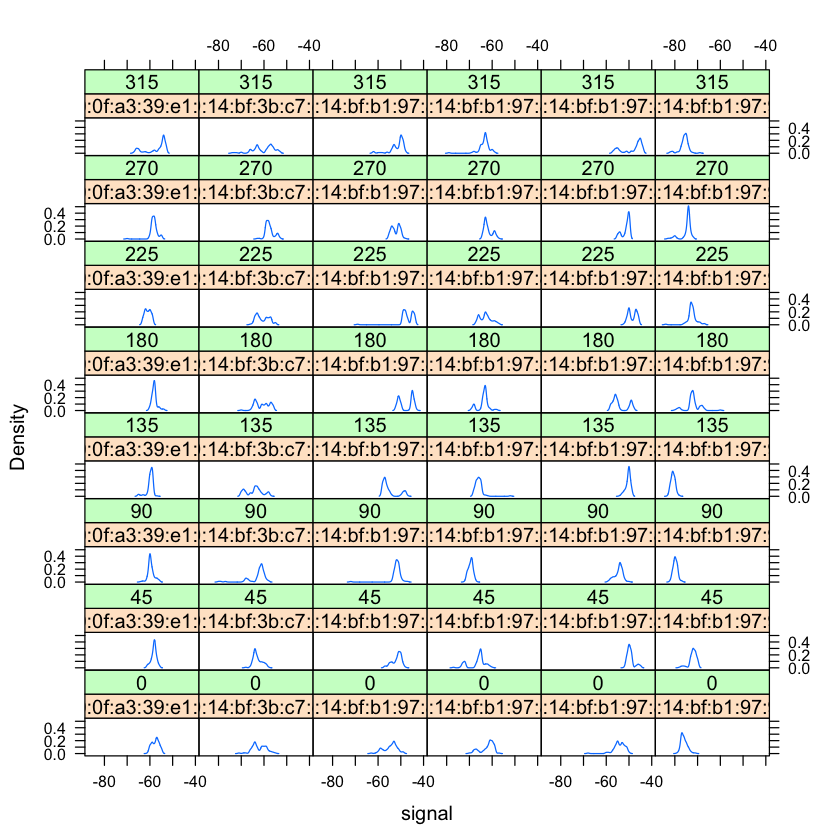

In [5]:
densityplot( ~ signal | mac + factor(angle), data = offline,
subset = posX == 24 & posY == 4 &
mac != "00:0f:a3:39:dd:cd",
bw = 0.5, plot.points = FALSE)

Examine the distribution of signal strength for all 166 locations,8 angles and 6 acess points using sumarry statitics

In [6]:
#Create a special factor that contains all of the unique combinations 
#of the observed (x, y) pairs for the 166 locations. 

offline$posXY = paste(offline$posX, offline$posY, sep = "-")

#create a list of data frames for every combination of (x, y), angle, and access point
byLocAngleAP = with(offline,
by(offline, list(posXY, angle, mac),
function(x) x))
   
#create summary statistics on each of the data frames
   
signalSummary =
lapply(byLocAngleAP,
function(oneLoc) {
ans = oneLoc[1, ]
ans$medSignal = median(oneLoc$signal)
ans$avgSignal = mean(oneLoc$signal)
ans$num = length(oneLoc$signal)
ans$sdSignal = sd(oneLoc$signal)
ans$iqrSignal = IQR(oneLoc$signal)
ans
})
   


In [7]:
offlineSummary = do.call("rbind", signalSummary)

Examine the standard deviations and see if they vary with the average signal
strength

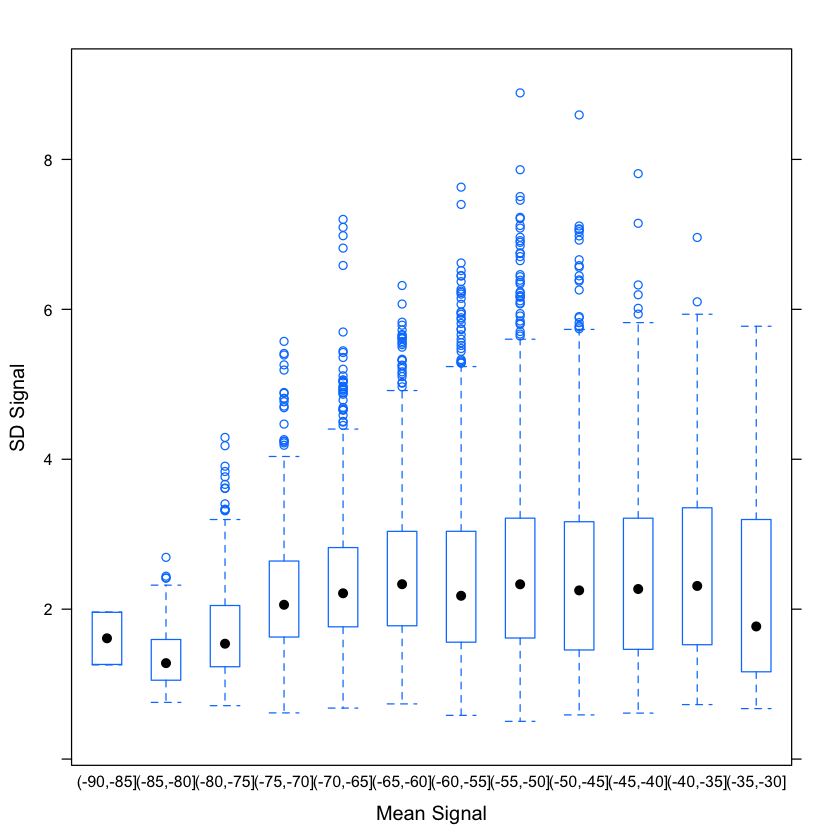

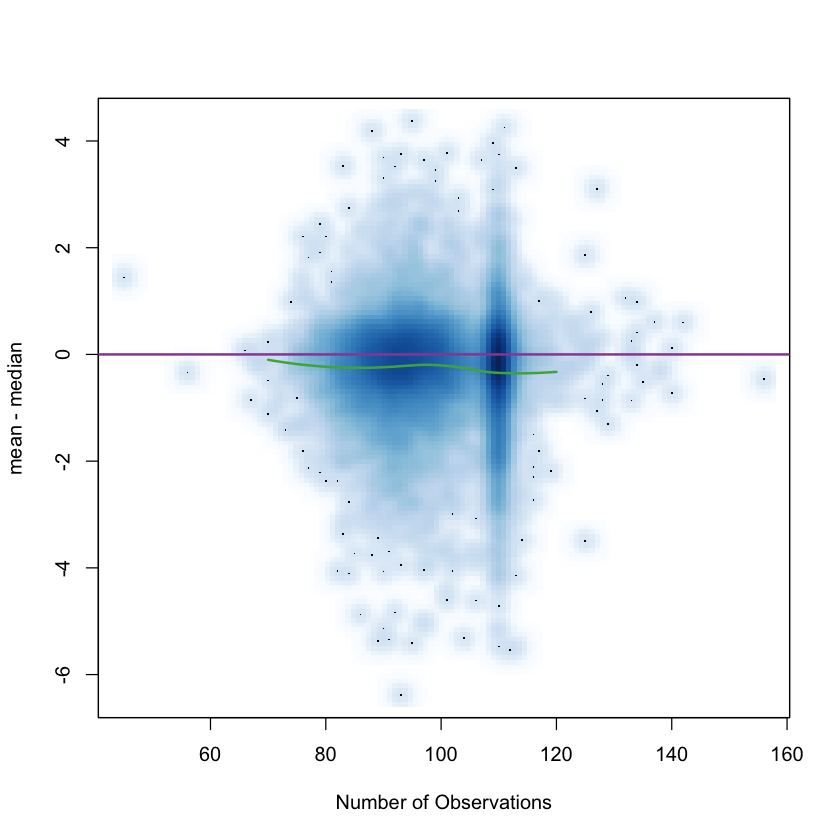

In [8]:
breaks = seq(-90, -30, by = 5)
bwplot(sdSignal ~ cut(avgSignal, breaks = breaks),
data = offlineSummary,
subset = mac != "00:0f:a3:39:dd:cd",
xlab = "Mean Signal", ylab = "SD Signal")

with(offlineSummary,
smoothScatter((avgSignal - medSignal) ~ num,
xlab = "Number of Observations",
ylab = "mean - median"))
abline(h = 0, col = "#984ea3", lwd = 2)


lo.obj =
with(offlineSummary,
loess(diff ~ num,
data = data.frame(diff = (avgSignal - medSignal),
num = num)))

lo.obj.pr = predict(lo.obj, newdata = data.frame(num = (70:120)))
lines(x = 70:120, y = lo.obj.pr, col = "#4daf4a", lwd = 2)


In [9]:
library(fields)
#get subMacs from previiys clean file 
subMacs = c('00:0f:a3:39:e1:c0', '00:0f:a3:39:dd:cd', '00:14:bf:b1:97:8a', '00:14:bf:3b:c7:c6', '00:14:bf:b1:97:90', '00:14:bf:b1:97:8d', '00:14:bf:b1:97:81')


oneAPAngle = subset(offline, mac == subMacs[5] & angle == 0)

oneAPAngle = subset(offlineSummary,
mac == subMacs[5] & angle == 0)


smoothSS = Tps(oneAPAngle[, c("posX","posY")],
oneAPAngle$avgSignal)

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


In [10]:
vizSmooth = predictSurface(smoothSS)

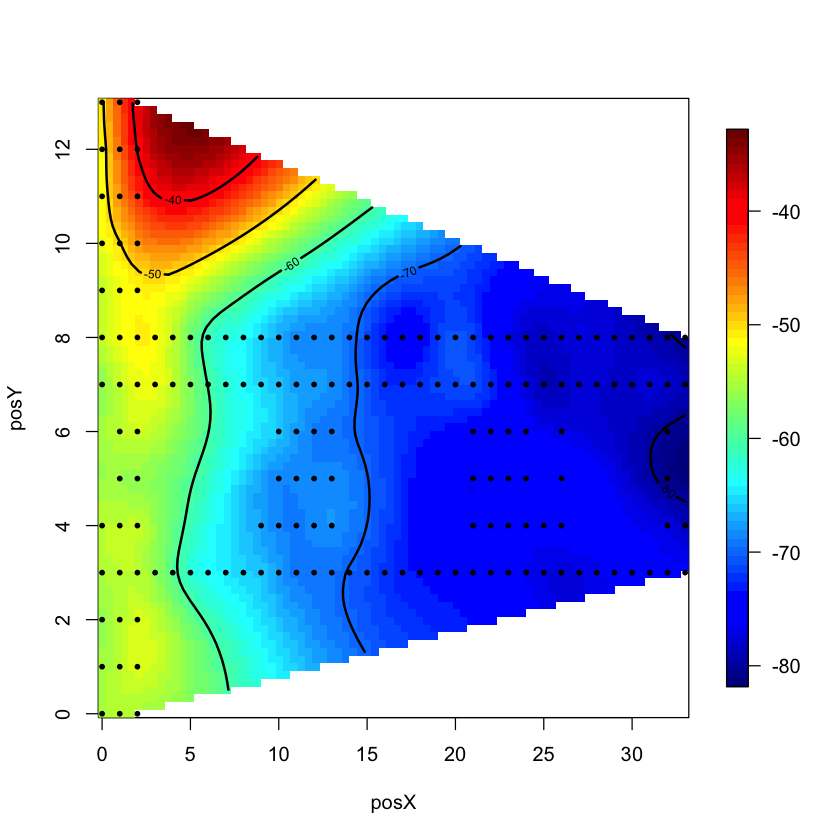

In [11]:
plot.surface(vizSmooth, type = "C")
points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5)

#missing function calll to create four plots

$`00:14:bf:b1:97:90`
NULL

$`00:14:bf:b1:97:90`
NULL

$`00:0f:a3:39:e1:c0`
NULL

$`00:0f:a3:39:e1:c0`
NULL

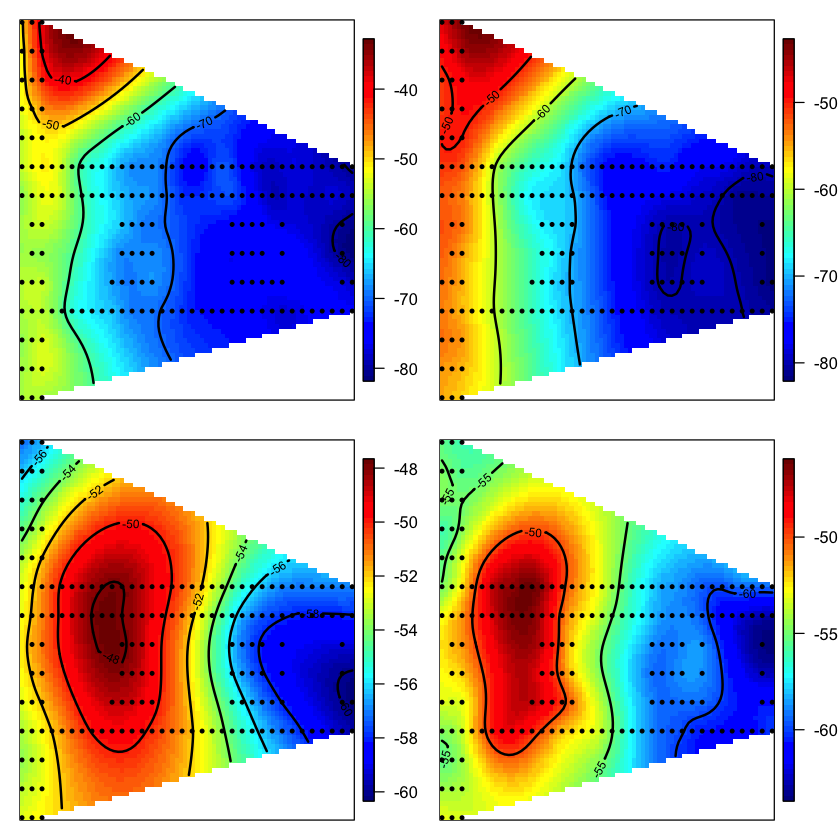

In [12]:
surfaceSS = function(data, mac, angle = 45) {
  require(fields)
  oneAPAngle = data[ data$mac == mac & data$angle == angle, ]
  smoothSS = Tps(oneAPAngle[, c("posX","posY")], 
                 oneAPAngle$avgSignal)
  vizSmooth = predictSurface(smoothSS)
  plot.surface(vizSmooth, type = "C", 
               xlab = "", ylab = "", xaxt = "n", yaxt = "n")
  points(oneAPAngle$posX, oneAPAngle$posY, pch=19, cex = 0.5) 
}

parCur = par(mfrow = c(2,2), mar = rep(1, 4))


mapply(surfaceSS, mac = subMacs[ rep(c(5, 1), each = 2) ],
angle = rep(c(0, 135), 2),
data = list(data = offlineSummary))

In [13]:
processLine = function(x)
{
  tokens = strsplit(x, "[;=,]")[[1]]
  
  if (length(tokens) == 10) 
    return(NULL)
 
  tmp = matrix(tokens[ - (1:10) ], , 4, byrow = TRUE)
  cbind(matrix(tokens[c(2, 4, 6:8, 10)], nrow(tmp), 6, 
               byrow = TRUE), tmp)
}

In [14]:
# Lang and Nolan bin these angles so they become more powerful class vars
roundOrientation = function(angles) {
  refs = seq(0, by = 45, length  = 9)
  q = sapply(angles, function(o) which.min(abs(o - refs)))
  c(refs[1:8], 0)[q]
}

In [15]:
readData = 
  function(filename = 'offline.final.trace.txt', 
           subMacs = c("00:0f:a3:39:e1:c0", "00:0f:a3:39:dd:cd", "00:14:bf:b1:97:8a",
                       "00:14:bf:3b:c7:c6", "00:14:bf:b1:97:90", "00:14:bf:b1:97:8d",
                       "00:14:bf:b1:97:81"))
  {
    txt = readLines(filename)
    lines = txt[ substr(txt, 1, 1) != "#" ]
    tmp = lapply(lines, processLine)
    offline = as.data.frame(do.call("rbind", tmp), 
                            stringsAsFactors= FALSE) 
    
    names(offline) = c("time", "scanMac", 
                       "posX", "posY", "posZ", "orientation", 
                       "mac", "signal", "channel", "type")
    
     # keep only signals from access points
    offline = offline[ offline$type == "3", ]
    
    # drop scanMac, posZ, channel, and type - no info in them
    dropVars = c("scanMac", "posZ", "channel", "type")
    offline = offline[ , !( names(offline) %in% dropVars ) ]
    
    # drop more unwanted access points
    offline = offline[ offline$mac %in% subMacs, ]
    
    # convert numeric values
    numVars = c("time", "posX", "posY", "orientation", "signal")
    offline[ numVars ] = lapply(offline[ numVars ], as.numeric)

    # convert time to POSIX
    offline$rawTime = offline$time
    offline$time = offline$time/1000
    class(offline$time) = c("POSIXt", "POSIXct")
    
    # round orientations to nearest 45
    offline$angle = roundOrientation(offline$orientation)
      
    return(offline)
  }

In [17]:
delete.me = function() {
    macs = unique(offlineSummary$mac)

    online$posXY = paste(online$posX, online$posY, sep = "-")

    length(unique(online$posXY))

    tabonlineXYA = table(online$posXY, online$angle)
    tabonlineXYA[1:6, ]

    keepVars = c("posXY", "posX","posY", "orientation", "angle")
    byLoc = with(online, 
                 by(online, list(posXY), 
                    function(x) {
                      ans = x[1, keepVars]
                      avgSS = tapply(x$signal, x$mac, mean)
                      y = matrix(avgSS, nrow = 1, ncol = 6,
                            dimnames = list(ans$posXY, names(avgSS)))
                      cbind(ans, y)
                    }))

}

# this is intentionally not run - we don't want it